# Models Overview
The library provides both basic and SR3-empowered implementations of modern
regularized regression algorithms. Below we give an overview of available options
and give advice on how to choose a model suitable for your goals.

## Table of Models

### Linear Models

Located in `pysr3.linear` submodule

Regularizer| without SR3 | with SR3 |
---- | --- | ----------- |
No regularization | `SimpleLinearModel` | `SimpleLinearModelSR3` |
L0 | `LinearL0Model` | `LinearL0ModelSR3` |
LASSO | `LinearL1Model` | `LinearL1ModelSR3` |
CAD | `LinearCADModel` | `LinearCADModelSR3` |
SCAD | `LinearSCADModel` | `LinearSCADModelSR3` |

The classes `LinearModel` is a base class that implements core functionality.

### Linear Mixed-Effects Models

Regularizer| without SR3 | with SR3 |
---- | --- | ----------- |
No regularization | `SimpleLMEModel` | `SimpleLMEModelSR3` |
L0 | `L0LmeModel` | `L0LmeModelSR3` |
LASSO | `L1LmeModel` | `L1LmeModelSR3` |
CAD | `CADLmeModel` | `CADLmeModelSR3` |
SCAD | `SCADLmeModel` | `SCADLmeModelSR3` |

The class `LMEModel` is a base class that implements core functionality.


## Regularizers

The library currently implements five popular regularizers: L0, LASSO, A-LASSO,
CAD, and SCAD. Below we plot the values and the proximal mappings for three of them:

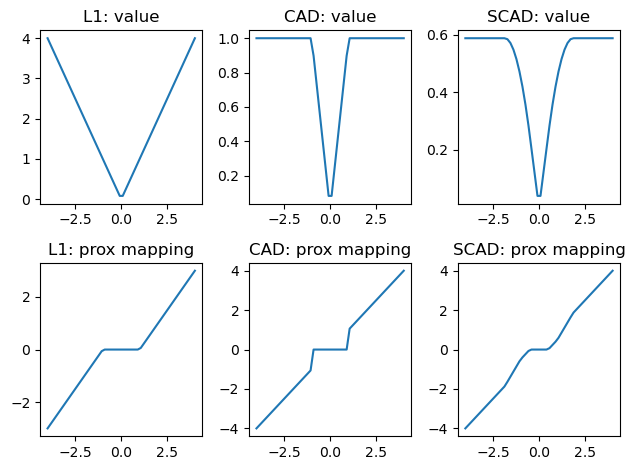

In [1]:
from pysr3.regularizers import L1Regularizer, CADRegularizer, SCADRegularizer
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(-4, 4)
fig, ax = plt.subplots(nrows=2, ncols=3)
for i, (name, regularizer) in enumerate({"L1": L1Regularizer(lam=1),
                                         "CAD": CADRegularizer(lam=1, rho=1),
                                         "SCAD": SCADRegularizer(lam=1, sigma=0.5, rho=3.7)}.items()):
    ax[0, i].plot(x, [regularizer.value(xi) for xi in x])
    ax[0, i].set_title(f"{name}: value")
    ax[1, i].plot(x, [regularizer.prox(xi, alpha=1) for xi in x])
    ax[1, i].set_title(f"{name}: prox mapping")
fig.tight_layout()
plt.show()

### L0

This is a regularizer that allows no more than a pre-defined number `k` of parameters to be non-zero:

$$R(x) = \delta (\|x\|_0 \leq k)$$

where $\delta$ is an indicator function.

### L1 (LASSO)
This is a well-known sparsity-promoting regularizer that penalizes the loss-funciton
with a sum of absolute values of the model's coefficients:

$$R(x) =  \lambda \|x\|_1$$

In `pysr3`, it's implemented as `pysr3.regularizers.L1Regularizer` class.

$\lambda$ is a hyper-parameter that controls the strength of the regularization.
Larger values of $\lambda$ lead to sparser sets of coefficients. The optimal value
is normally set via cross-validation grid-search that minimizes an information
criterion of the choice (AIC, BIC, e.t.c.) on a validation part of the splits.
See the example in Quickstart tutorial.

### Adaptive LASSO (A-LASSO)

Adaptive LASSO uses $\bar{x}$ -- a solution for a non-regularized problem -- as weights
for LASSO penalty:

$$R(x) = \lambda\sum_{i=1}^n \frac{|x_i|}{|\bar{x}_i|}$$

In `pysr3`, A-LASSO can be implemented by providing custom regularization weights
to LASSO model:

In [2]:
from pysr3.linear.problems import LinearProblem
from pysr3.linear.models import SimpleLinearModel, LinearL1Model

x, y = LinearProblem.generate(num_objects=100, num_features=200, true_x=[0, 1]*100).to_x_y()
non_regularized_coefficients = SimpleLinearModel().fit(x, y).coef_["x"]
regularization_weights = 1/(non_regularized_coefficients + 1e-3)  # safeguard against zeros in the denominator
alasso_model = LinearL1Model(lam=1).fit(x, y, regularization_weights=regularization_weights)

### CAD
Clipped Absolute Deviation (CAD) penalty is a clipped version of LASSO. When the values
of the coefficients are less than a hyper-parameter $\rho$ -- it works like LASSO,
but it does not penalize the coefficients that are bigger than that in their absolute
value. It addresses an issue of LASSO penalizing big coefficients too much.

In `pysr3`, CAD regularizer is implemented as `pysr3.regularizers.CADRegularizer`.

### SCAD
Smooth Clipped Absolute Deviation (SCAD) penalty is a smoothed version of SCAD.
Instead of imposing a hard threshold, it uses 2-knot smooth spline interpolation
to connect the flat and the absolute value parts. The knots of the spline
are located at points $\rho$ and $\sigma\rho$.

In `pysr3`, SCAD regularizer is implemented as `pysr3.regularizers.CADRegularizer`.

## Regular PGD vs SR3-PGD
Proximal Gradient Descent (PGD) is currently the core numerical solver for `pysr3`.
It has a very simple form of iteration that requires only gradient information
of the loss function and the proximal operator of the regularizer:

$x_{k+1} = \text{prox}_{\alpha R}(x_k - \alpha \nabla f(x_k))$

The core methodological innovation of `pysr3` is Sparse Relaxed
Regularized Regression (SR3) framework. It improves the conditioning of the
loss function, that leads to faster convergence and more accurate
feature selection.

The picture below illustrates how SR3 changes the landscape of the likelihood for
a Linear Mixed-Effect Model. Notice that the same optimization method takes
nearly two orders of magnitude less iterations to converge.

![](sr3_mixed_intuition.png)

Every model in pysr3 has its SR3-empowered version. For all of them, the parameter `ell` controls the degree of relaxation, with larger parameter values giving tighter relaxations. `ell` can be left to its default value or can be found via grid-search simultaneously with $\lambda$.